In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import seaborn as sns
from locale import normalize
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
spa_counts = np.load('../../data/ST/Starmap/visual_1020/20180505_BY3_1kgenes/cell_barcode_count.npy')

coordinates = pd.read_csv("../../data/ST/Starmap/visual_1020/20180505_BY3_1kgenes/centroids.tsv", header=None, sep='\t')

scrna_adata = sc.read("../../data/scRNAseq/Allen_VISp/mouse_VISp_2018-06-14_exon-matrix.csv").T
genes = pd.read_csv("../../data/scRNAseq/Allen_VISp/mouse_VISp_2018-06-14_genes-rows.csv", header=0,sep=',')
VISp_meta = pd.read_csv("../../data/scRNAseq/Allen_VISp/mouse_VISp_2018-06-14_samples-columns.csv", header=0,sep=',')
scrna_adata.obs = VISp_meta
scrna_adata.var_names = genes.gene_symbol

sc.pp.filter_genes(scrna_adata, min_cells=10)
scrna_adata = scrna_adata[(scrna_adata.obs['class'] != 'No Class') & (scrna_adata.obs['class'] != 'Low Quality')]
classes, ct_list = leiden_cluster(scrna_adata)
cls_key = 'leiden'
scrna_adata.obs[cls_key] = classes
sc.pp.normalize_total(scrna_adata)
sc.pp.log1p(scrna_adata)

spa_adata = sc.AnnData(spa_counts)

sc.pp.normalize_total(spa_adata)
sc.pp.log1p(spa_adata)

genes = pd.read_csv("../../data/ST/Starmap/visual_1020/20180505_BY3_1kgenes/genes.csv", header=None).iloc[:,0]
spa_adata.obs['X'] = coordinates.iloc[:, 0].values
spa_adata.obs['Y'] = coordinates.iloc[:, 1].values
spa_adata.var_names = genes

shared_genes = np.intersect1d(scrna_adata.var_names, genes)
scrna_adata = scrna_adata[:, shared_genes]
spa_adata   = spa_adata[:, shared_genes]

spa_adata.obsm['spatial'] = np.hstack([spa_adata.obs.X.values.reshape(-1,1), spa_adata.obs.Y.values.reshape(-1,1)])
df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
sq.gr.spatial_neighbors(spa_adata, n_neighs=20)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
imp_adatas = {}
output_root = "../../output"
eval_res = {'se_moranI':{}, 'pred_corr':{}, 'I':{}}
for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', 'transImpCls', 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue  
    spa, rna, method = file.split(".")[0].split('_')
    if spa.lower() != 'starmap': continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    imp_adata = sc.AnnData(df_res.values)
    imp_adata.var_names = df_res.columns
    imp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    
    imp_adatas[method] = imp_adata
    imp_adatas[method] = imp_adata
    corrs = calc_corr(df_spa, df_res, df_res.columns)
    sq.gr.spatial_neighbors(imp_adata, n_neighs=20)
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=20,
        mode='moran',
    )
    sel = (~np.isnan(imp_adata.uns['moranI'].I))
    
  
    if np.sum(sel) < imp_adata.n_vars:
        print(f'({spa} {rna} {method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I[sel] - imp_adata.uns['moranI'].I[sel])
    eval_res['se_moranI'][method] = squ_err_moranI
    eval_res['pred_corr'][method] = pd.Series(corrs, df_res.columns)
    eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I[sel], df_res.columns)

Trying to set attribute `.obs` of view, copying.


In [3]:
TransImpSpa_reduced_err_wrt_tangram = np.median((eval_res['se_moranI']["Tangram"] - eval_res['se_moranI']["transImpSpa"]) / eval_res['se_moranI']["Tangram"])
print(f"TransImpSpa avg. reduced err wrt tangram: {TransImpSpa_reduced_err_wrt_tangram:.3}")

TransImpSpa avg. reduced err wrt tangram: 0.754


In [4]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_I         = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_I['truth'] = spa_adata.uns['moranI'].loc[df_I.index.values,:].I
imp_adatas = dict(sorted(imp_adatas.items()))

[Text(0, 0.5, 'Spearman Correlation Coefficient')]

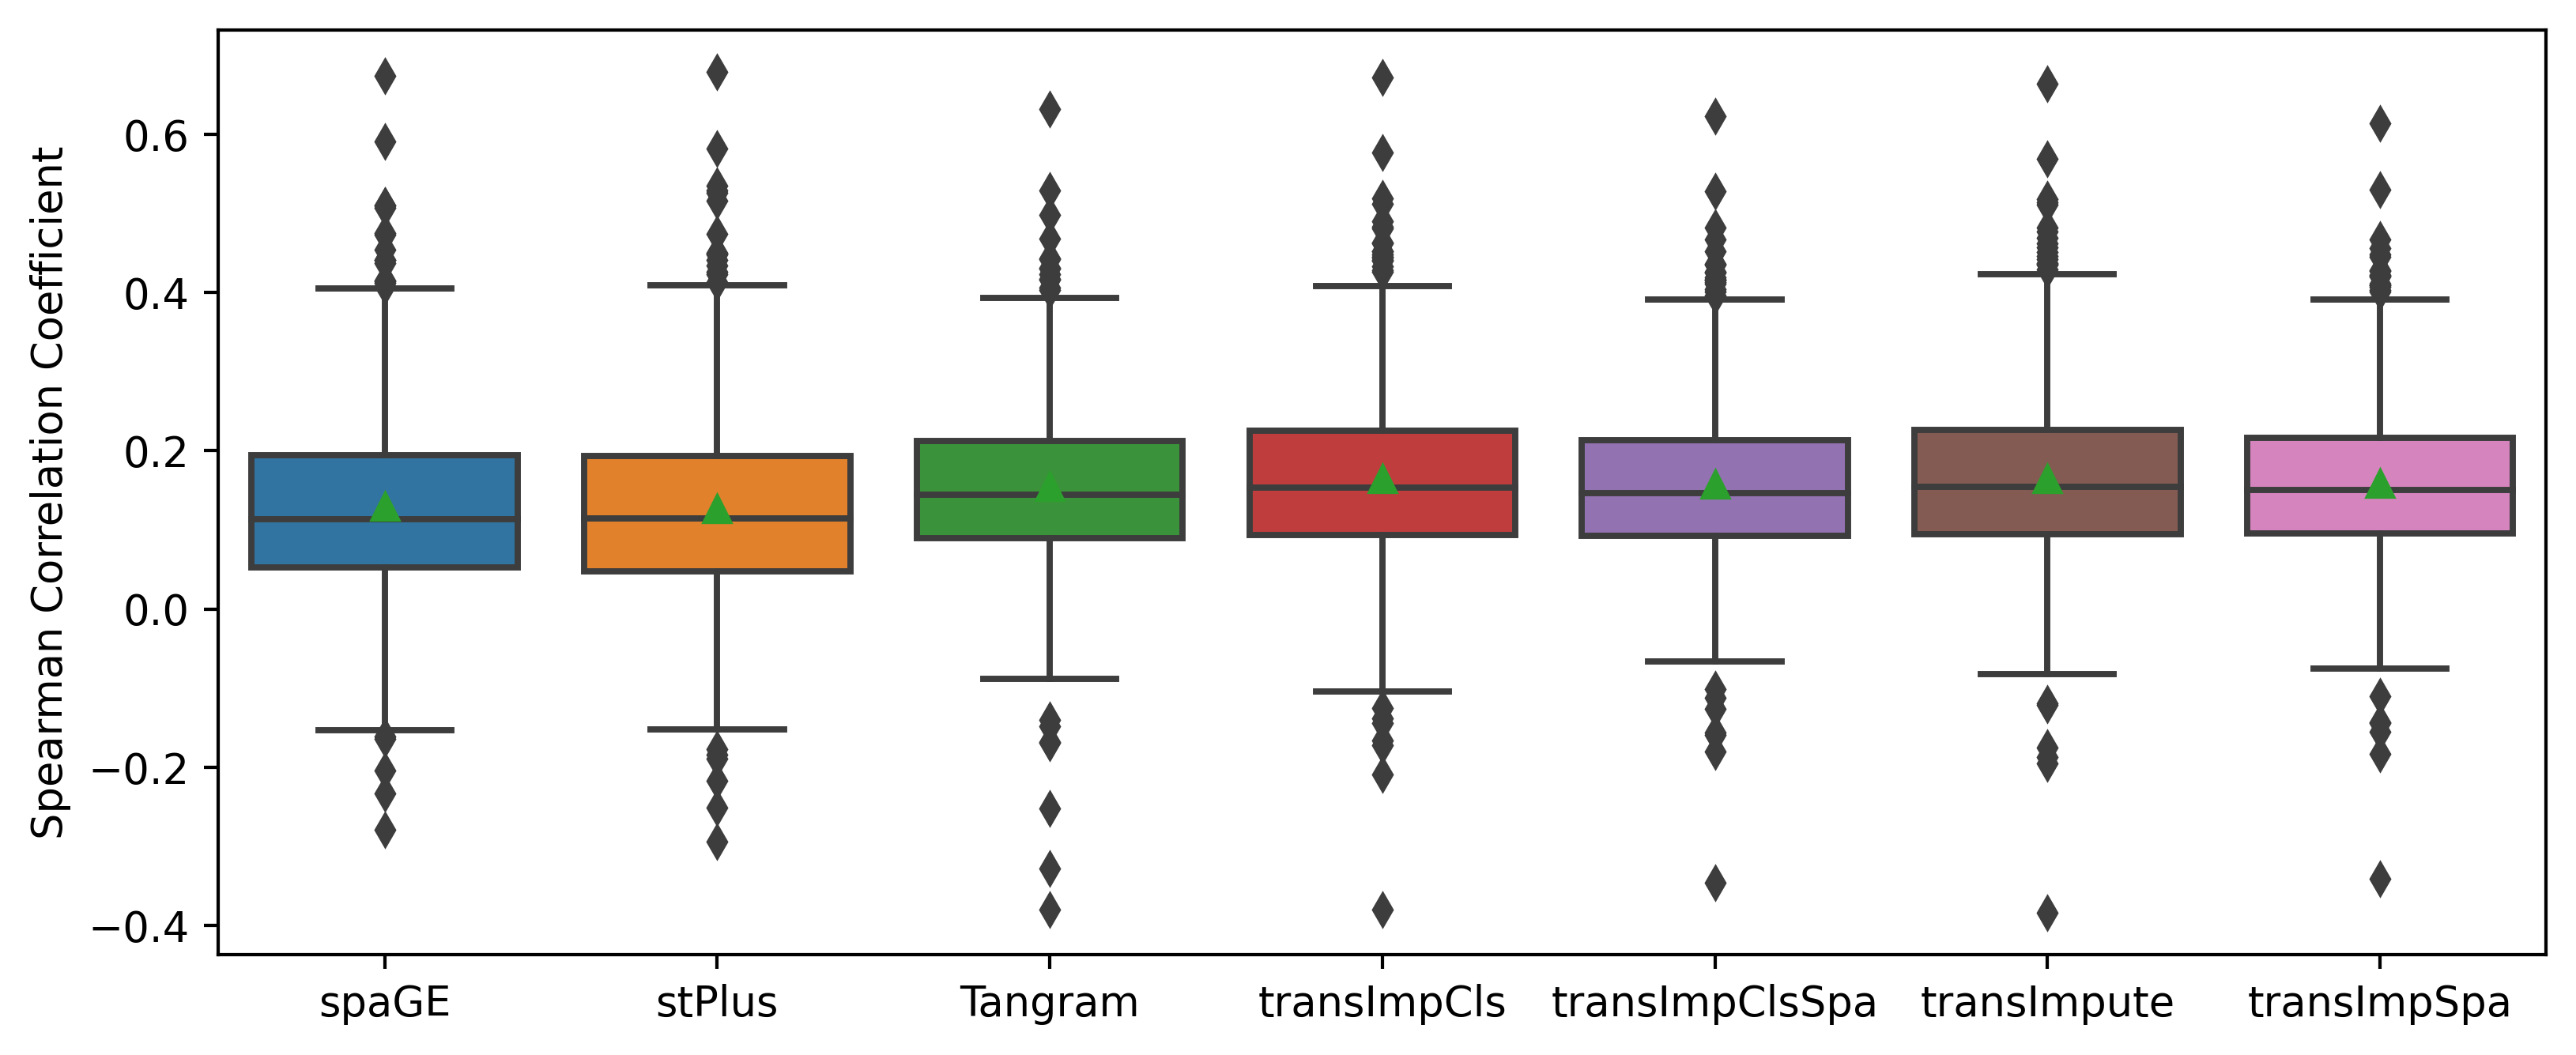

In [5]:
plt.figure(figsize=(10, 4), dpi= 380)
method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
sns.boxplot(data = df_corr, showmeans=True, order=method_order).set(
    ylabel='Spearman Correlation Coefficient'
)

[Text(0, 0.5, "Moran's I Mean Squared Error")]

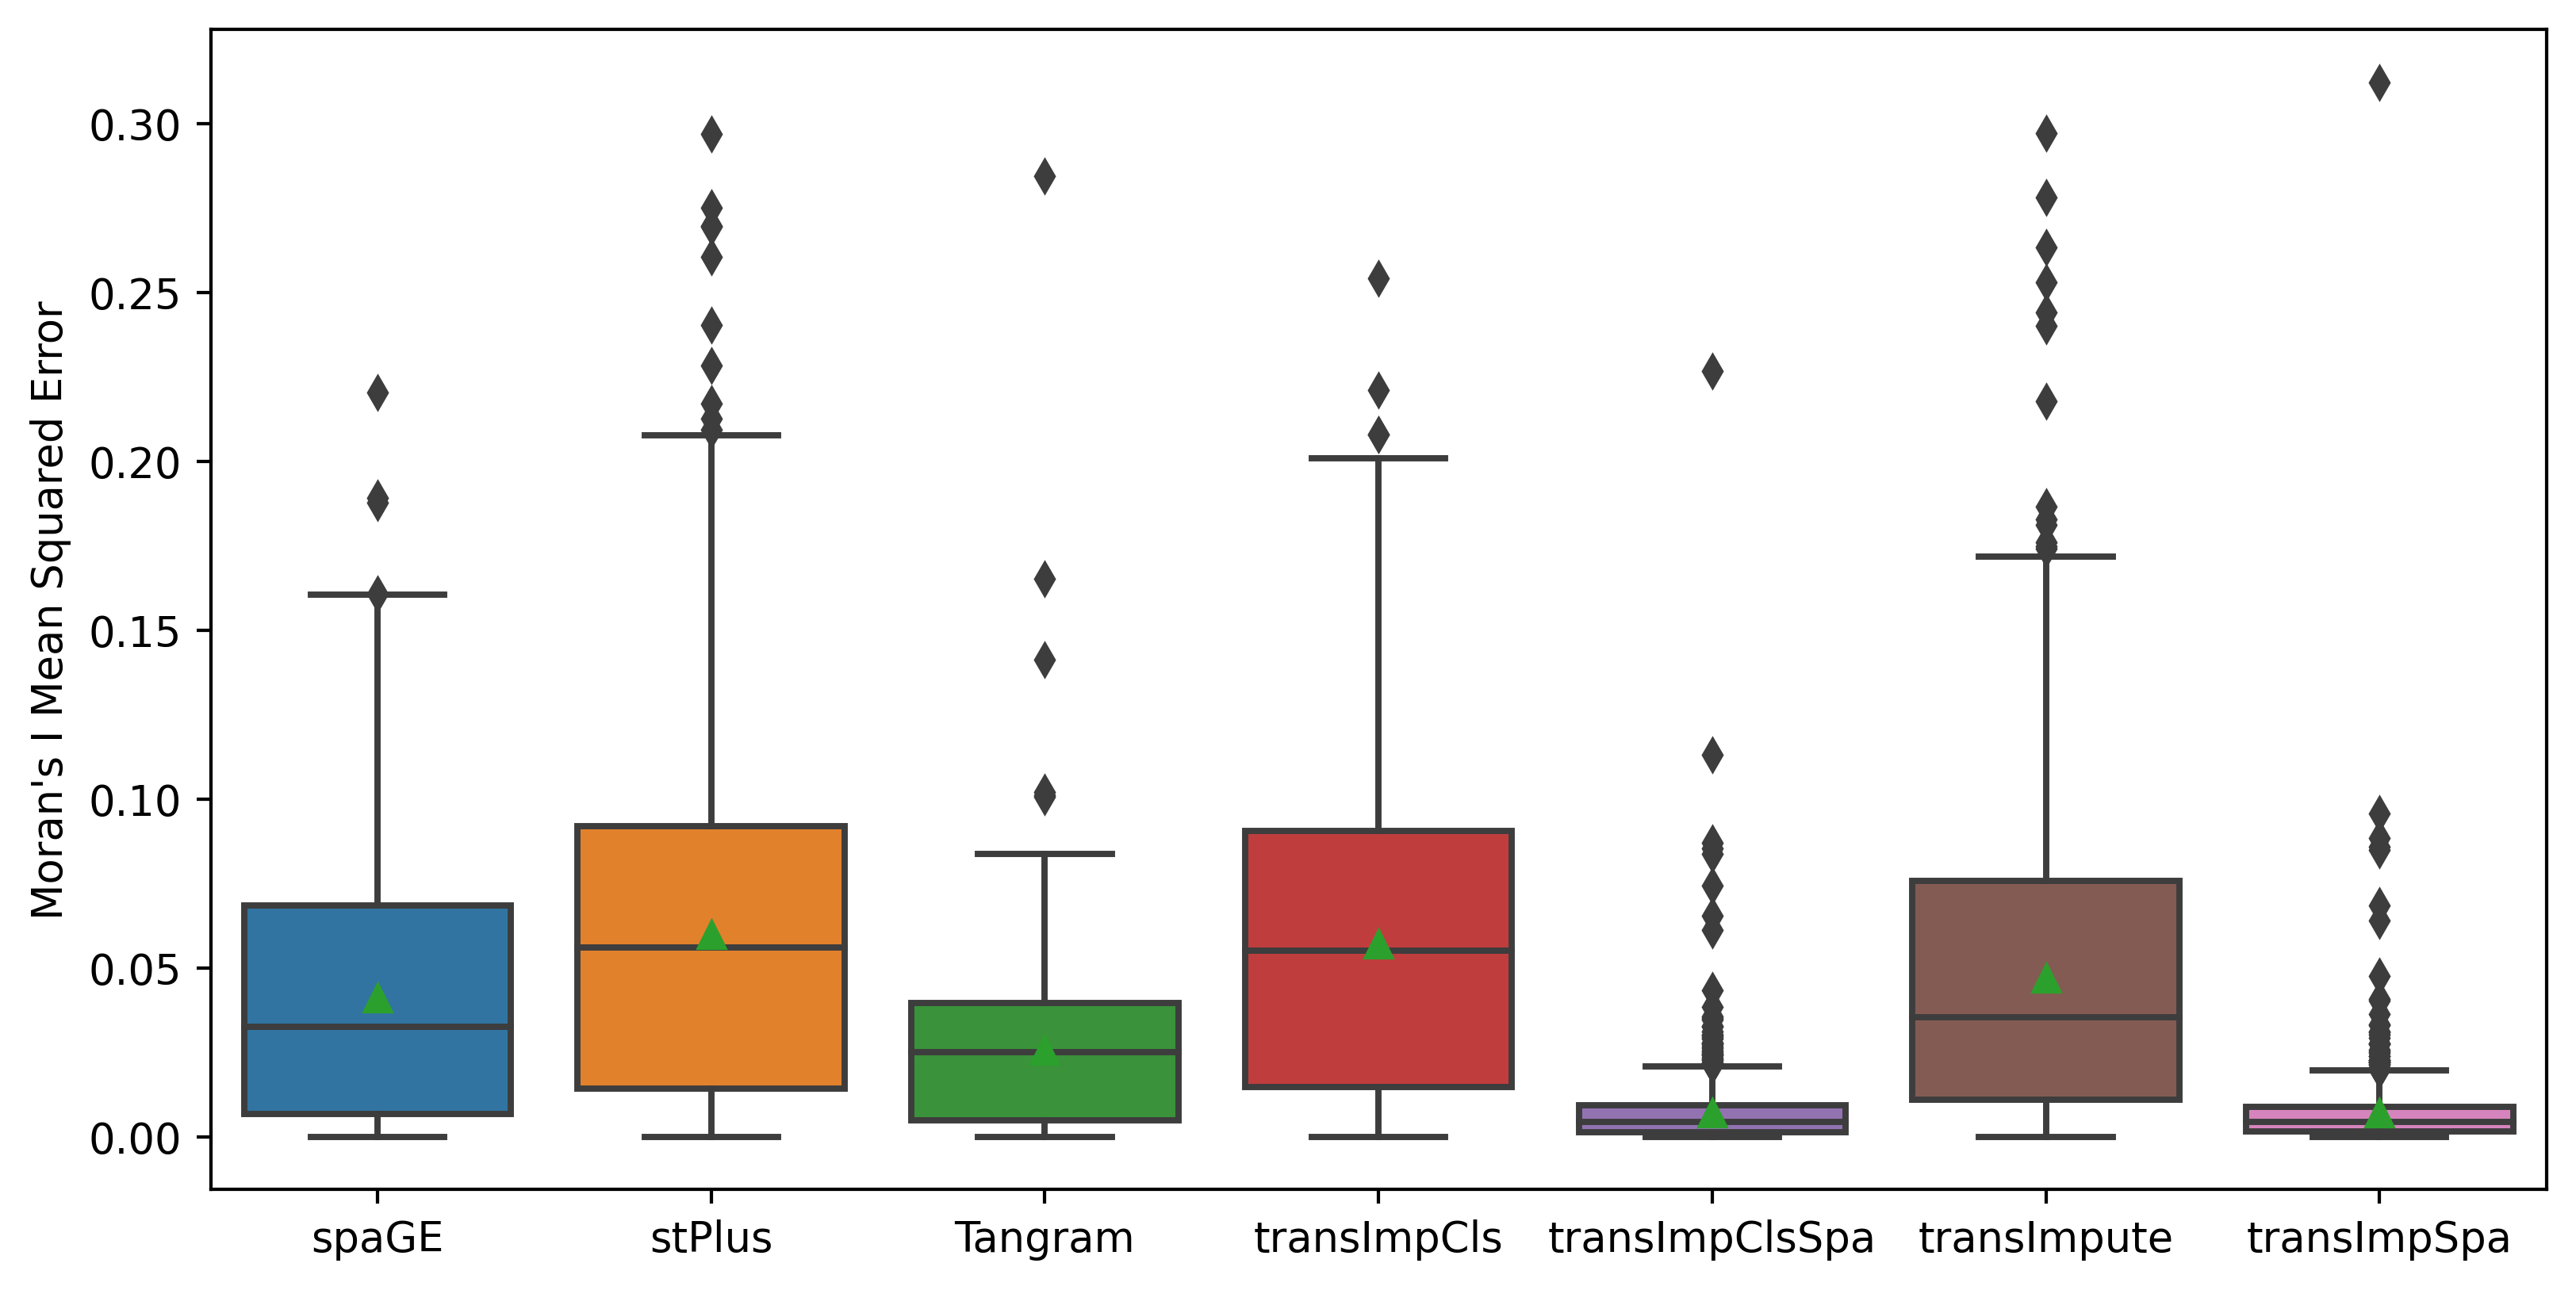

In [6]:
plt.figure(figsize=(10, 5), dpi= 380)
sns.boxplot(data = df_se_moranI, showmeans=True, order=method_order).set(
    ylabel="Moran's I Mean Squared Error"
)

In [7]:
from sklearn.neighbors import kneighbors_graph
n_clusters = 10
print(f"{n_clusters} clusters")
sc.tl.pca(spa_adata)
real_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                    connectivity=spa_adata.obsp['spatial_connectivities'],
                                    ).fit_predict(spa_adata.obsm['X_pca'])
spa_cluster_metrics = {}
for method in sorted(imp_adatas.keys()):
    imp_adata = imp_adatas[method]
    sc.tl.pca(imp_adata)
    pred_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                         connectivity=spa_adata.obsp['spatial_connectivities'],
                                         ).fit_predict(imp_adata.obsm['X_pca'])
    ars = adjusted_rand_score(real_clss, pred_clss)
    amis = adjusted_mutual_info_score(real_clss, pred_clss)
    homo = homogeneity_score(real_clss, pred_clss)
    nmi = normalized_mutual_info_score(real_clss, pred_clss)
    spa_cluster_metrics[method] = {"ARS":ars, "AMIS":amis, 'HOMO': homo, 'NMI':nmi}
    pd.DataFrame(spa_cluster_metrics).to_csv("../../output/clustering/starmap_AllenVISp.csv")
    print(f"Cluster on Raw Expression vs  on {method} Predicted Expression\n - ARS: {ars:.6f}, AMIS: {amis:.6f}, HOMO: {homo:.6f}, NMI: {nmi:.6f}")

10 clusters
Cluster on Raw Expression vs  on Tangram Predicted Expression
 - ARS: 0.214200, AMIS: 0.373215, HOMO: 0.386696, NMI: 0.381392
Cluster on Raw Expression vs  on spaGE Predicted Expression
 - ARS: 0.255384, AMIS: 0.448204, HOMO: 0.454990, NMI: 0.455513
Cluster on Raw Expression vs  on stPlus Predicted Expression
 - ARS: 0.239823, AMIS: 0.411138, HOMO: 0.410270, NMI: 0.419101
Cluster on Raw Expression vs  on transImpCls Predicted Expression
 - ARS: 0.281209, AMIS: 0.467205, HOMO: 0.453345, NMI: 0.474539
Cluster on Raw Expression vs  on transImpClsSpa Predicted Expression
 - ARS: 0.264528, AMIS: 0.371718, HOMO: 0.370767, NMI: 0.380247
Cluster on Raw Expression vs  on transImpSpa Predicted Expression
 - ARS: 0.228116, AMIS: 0.397126, HOMO: 0.413697, NMI: 0.404936
Cluster on Raw Expression vs  on transImpute Predicted Expression
 - ARS: 0.272741, AMIS: 0.446459, HOMO: 0.437184, NMI: 0.454021


transImpute pred - true ratio above 0.1: 0.770624
transImpCls pred - true ratio above 0.1: 0.808853
transImpSpa pred - true ratio above 0.1: 0.200201
transImpClsSpa pred - true ratio above 0.1: 0.208249
stPlus pred - true ratio above 0.1: 0.792757
Tangram pred - true ratio above 0.1: 0.670020
spaGE pred - true ratio above 0.1: 0.686117


Text(0.5, 0.98, "True Moran's I v.s. (Pred - True) Moran's I")

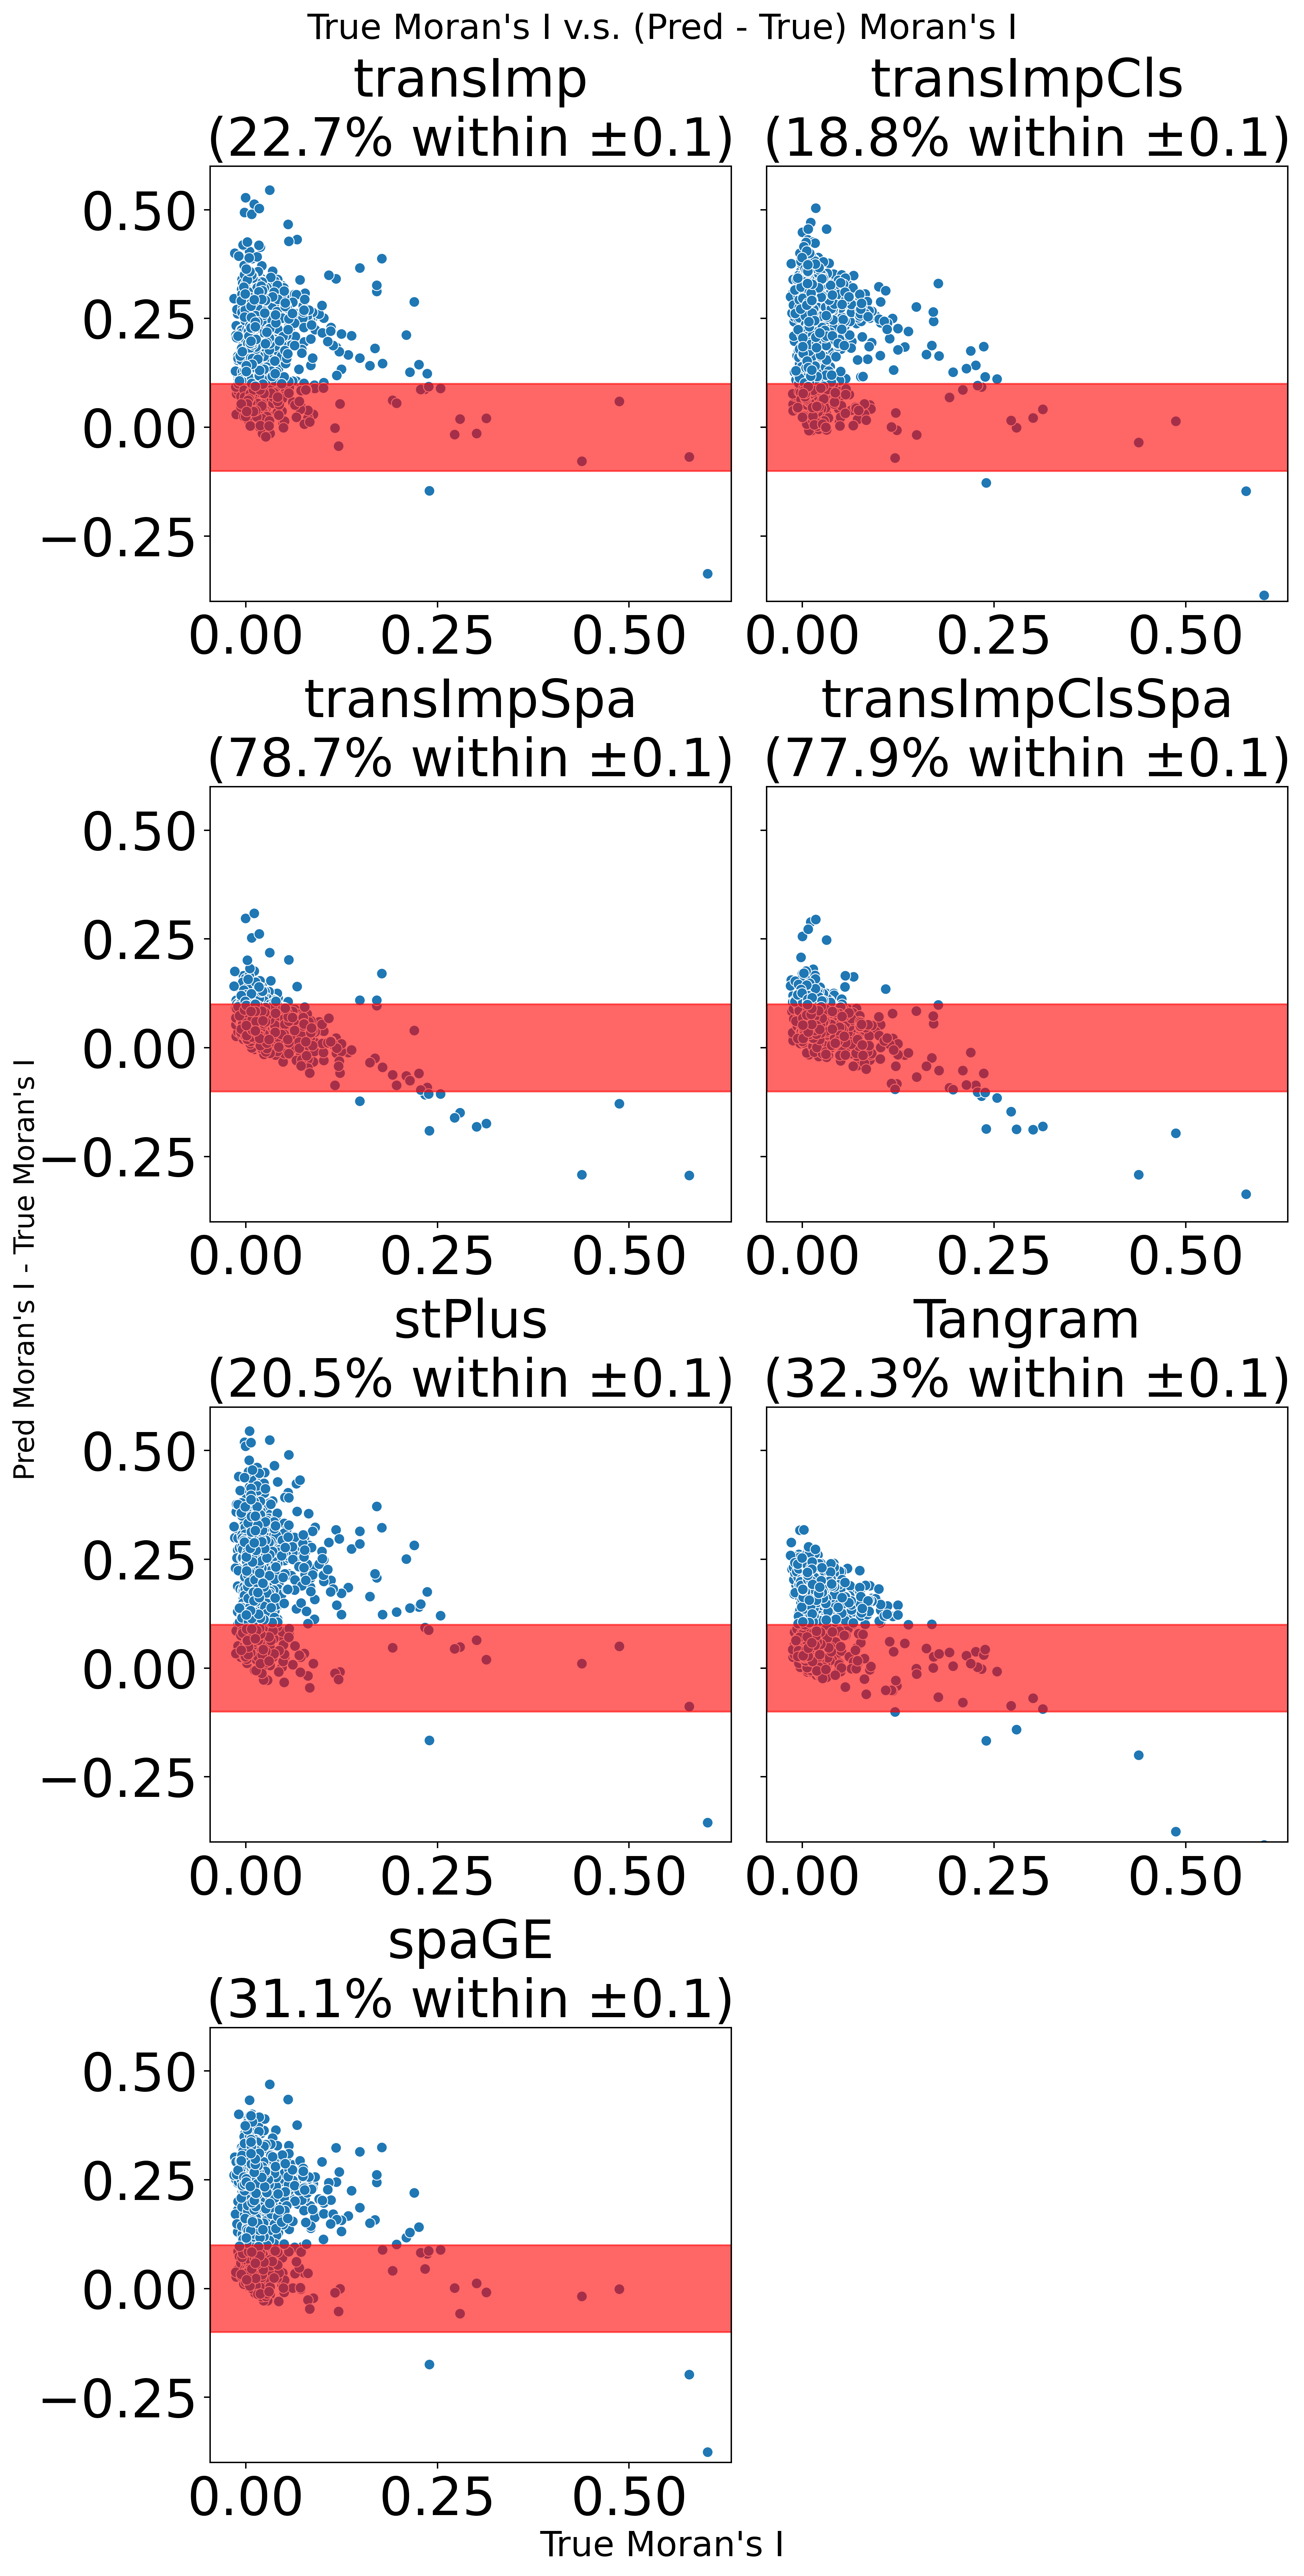

In [8]:
plt.rcParams.update({"font.size":30, 'axes.titlesize':30})

fig, axis = plt.subplots(4,2, sharey=True, constrained_layout=True)
fig.set_figwidth(10)
fig.set_figheight(20)
fig.set_dpi(350)
for idx, method in enumerate(['transImpute', 'transImpCls', 'transImpSpa', 'transImpClsSpa', 'stPlus', 'Tangram', 'spaGE', None]):
    
    ax = axis[idx//2, idx%2]
    if method is None:
        ax.axis('off')
        break    
    ax.axis(ymin=-0.4, ymax=0.6)
    sns.scatterplot(x=df_I.truth, y=df_I[method]-df_I.truth, ax=ax)
    ratio = (np.abs(df_I.truth-df_I[method]) < 0.1).sum()/df_I.shape[0]
    neg_ratio = ((df_I.truth-df_I[method]) < -0.1).sum()/df_I.shape[0]
    print(f"{method} pred - true ratio above 0.1: {neg_ratio:.6f}")
    ax.axhspan(-0.1, 0.1, facecolor='0.5', alpha=0.6, color='r')
    ax.set_title(f'{method if method != "transImpute" else "transImp"}\n({ratio:.1%} within ±0.1)')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
fig.text(0.5, -0.01, "True Moran's I", ha='center', fontsize=20)    
fig.text(-0.015, 0.5, "Pred Moran's I - True Moran's I", va='center', rotation='vertical', fontsize=16)
fig.suptitle("True Moran's I v.s. (Pred - True) Moran's I", fontsize=20)
# fig.savefig("../../output/seqfish_moranI_cmp.png", dpi=350)